In [1]:
import pygame
import numpy as np
import gym
from gym import spaces
import time
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class MazeEnv(gym.Env):
    def __init__(self, maze, screen):
        super(MazeEnv, self).__init__()
        self.maze = maze
        self.rows, self.cols = maze.shape
        self.robot_position = (0, 0)
        self.exit_position = (self.rows - 1, self.cols - 1)
        self.screen = screen
        self.score = 0 
        self.path_taken = []  

        self.action_space = spaces.Discrete(8)  
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.rows),
            spaces.Discrete(self.cols)
        ))

        # Define rewards
        self.passive_reward = -1
        self.exit_reward = 100
        self.collision_penalty = -10

        # Q-learning parameters
        self.epsilon = 0.8
        self.gamma = 0.5
        self.q_table = np.zeros((self.rows, self.cols, self.action_space.n))
        self.alpha = 0.05

        self.reset()

    def reset(self):
        self.robot_position = (0, 0)
        self.score = 0  # Reset score to 0
        self.path_taken = []  # Reset path taken
        return self.robot_position

    def step(self, action):
        row, col = self.robot_position
        if action == 0:  # move up
            row -= 1
        elif action == 1:  # move down
            row += 1
        elif action == 2:  # move left
            col -= 1
        elif action == 3:  # move right
            col += 1
        elif action == 4:  # move up-left
            row -= 1
            col -= 1
        elif action == 5:  # move up-right
            row -= 1
            col += 1
        elif action == 6:  # move down-left
            row += 1
            col -= 1
        elif action == 7:  # move down-right
            row += 1
            col += 1

        # Ensure the robot stays within the maze
        row = max(0, min(row, self.rows - 1))
        col = max(0, min(col, self.cols - 1))

        # Check if the new position is a wall
        if self.maze[row][col] == 1:
            reward = self.collision_penalty
        else:
            self.robot_position = (row, col)
            if self.robot_position == self.exit_position:
                reward = self.exit_reward  # Reached the exit
            else:
                reward = self.passive_reward  # Moved to a valid position

        # Update score
        self.score += reward

        # Update path taken
        self.path_taken.append(self.robot_position)

        # Update Q-table
        old_q_value = self.q_table[self.robot_position[0], self.robot_position[1], action]
        max_future_q = np.max(self.q_table[self.robot_position[0], self.robot_position[1]])
        new_q_value = (1 - self.alpha) * old_q_value + self.alpha * (reward + self.gamma * max_future_q)
        self.q_table[self.robot_position[0], self.robot_position[1], action] = new_q_value

        done = self.robot_position == self.exit_position
        return self.robot_position, reward, done, {'score': self.score}  # Return score in the info dict

    def choose_action(self):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.action_space.n)  # Choose random action
        else:
            return np.argmax(self.q_table[self.robot_position[0], self.robot_position[1]])  # Choose best action

    def get_path_taken(self):
        return self.path_taken

    def render(self):
        cell_width = 30
        cell_height = 30

        # Load images
        robot_image = pygame.image.load("robot.png")
        robot_image = pygame.transform.scale(robot_image, (cell_width, cell_height))
        exit_image = pygame.image.load("exit.png")
        exit_image = pygame.transform.scale(exit_image, (cell_width, cell_height))

        # Draw maze walls and paths
        for row in range(self.rows):
            for col in range(self.cols):
                if self.maze[row][col] == 1:
                    pygame.draw.rect(self.screen, (0, 0, 255), (col * cell_width, row * cell_height, cell_width, cell_height))  # Blue block for walls
                else:
                    if (row, col) == self.robot_position:
                        pygame.draw.rect(self.screen, (0, 255, 0), (col * cell_width, row * cell_height, cell_width, cell_height))  # Green block for robot position
                    else:
                        pygame.draw.rect(self.screen, (255, 255, 255), (col * cell_width, row * cell_height, cell_width, cell_height))  # White block for paths

        # Draw robot and exit positions
        self.screen.blit(robot_image, (self.robot_position[1] * cell_width, self.robot_position[0] * cell_height))  # Robot
        self.screen.blit(exit_image, (self.exit_position[1] * cell_width, self.exit_position[0] * cell_height))  # Exit

        # Render score text
        font = pygame.font.SysFont(None, 25)
        score_text = font.render(f'Score: {self.score}', True, (255, 255, 255))
        self.screen.blit(score_text, (10, self.rows * cell_height + 10))  # Adjusted position for score text

        pygame.display.flip()

Testing maze size: (7, 7)
Elapsed time: 562.1135423183441 seconds
Number of cycles: 19587
Elapsed time: 5.6472084522247314 seconds
Number of cycles: 199

Results:
Maze size (7, 7):
Default Hyperparameters - Cycles=19587, Time=562.1135423183441 seconds
Optimal Hyperparameters - Cycles=199, Time=5.6472084522247314 seconds


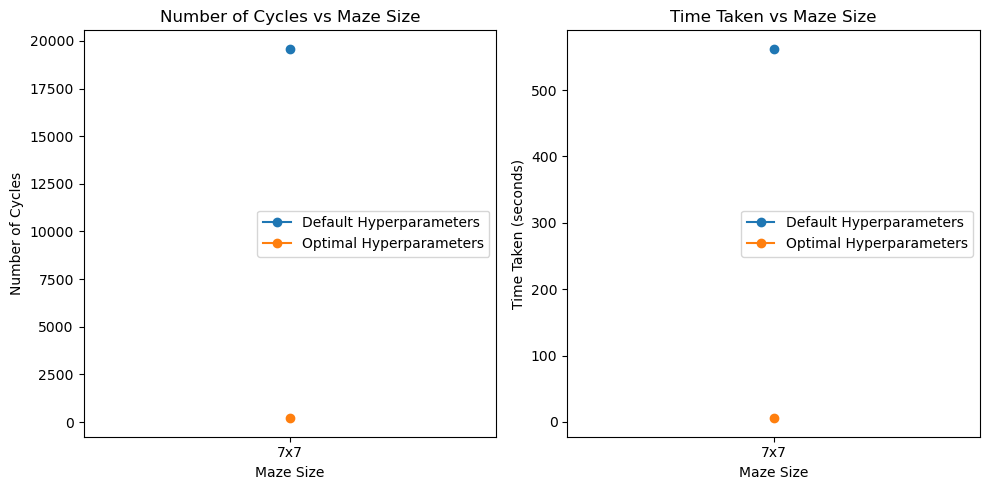

In [3]:
def main(rows, cols, alpha, gamma, epsilon):
    maze_layout = np.zeros((rows, cols))

    start_row, start_col = 0, 1
    exit_row, exit_col = rows - 1, cols - 2
    maze_layout[start_row, start_col] = 0  # Starting position
    maze_layout[exit_row, exit_col] = 0  # Exit position

    # Add random walls
    num_walls = int(0.1 * (rows * cols))  # Wall density: 10% of total cells
    for _ in range(num_walls):
        row, col = np.random.randint(1, rows - 1), np.random.randint(1, cols - 1)
        maze_layout[row, col] = 1  # Set cell to be a wall

    # Initialize Pygame
    pygame.init()
    pygame.display.set_caption("Maze Game")
    screen = pygame.display.set_mode((cols * 30, rows * 30))

    env = MazeEnv(maze_layout, screen)
    env.alpha = alpha
    env.gamma = gamma
    env.epsilon = epsilon

    start_time = time.time()

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        action = env.choose_action()  # Choose action based on ε-greedy policy
        observation, reward, done, info = env.step(action)
        env.render()
        pygame.time.wait(1)  # Delay for visualization

        if done:  # Exit the main loop if done
            running = False

    end_time = time.time()
    elapsed_time = end_time - start_time
    pygame.quit()

    print("Elapsed time:", elapsed_time, "seconds")

    path_taken = env.get_path_taken()
    print("Number of cycles:", len(path_taken))

    return len(path_taken), elapsed_time



if __name__ == "__main__":
    sizes = [(7, 7)]
    default_results = []
    optimal_results = []

    default_hyperparams = {
        'alpha': 0.1,
        'gamma': 0.9,
        'epsilon': 0.3
    }

    optimal_hyperparams = {
        'alpha': 0.05,
        'gamma': 0.5,
        'epsilon': 0.8
    }

    for size in sizes:
        print(f"Testing maze size: {size}")
        cycles_default, time_default = main(*size, **default_hyperparams)
        default_results.append((cycles_default, time_default))

        cycles_optimal, time_optimal = main(*size, **optimal_hyperparams)
        optimal_results.append((cycles_optimal, time_optimal))

    print("\nResults:")
    for size, default_result, optimal_result in zip(sizes, default_results, optimal_results):
        print(f"Maze size {size}:")
        print("Default Hyperparameters - Cycles={}, Time={} seconds".format(default_result[0], default_result[1]))
        print("Optimal Hyperparameters - Cycles={}, Time={} seconds".format(optimal_result[0], optimal_result[1]))



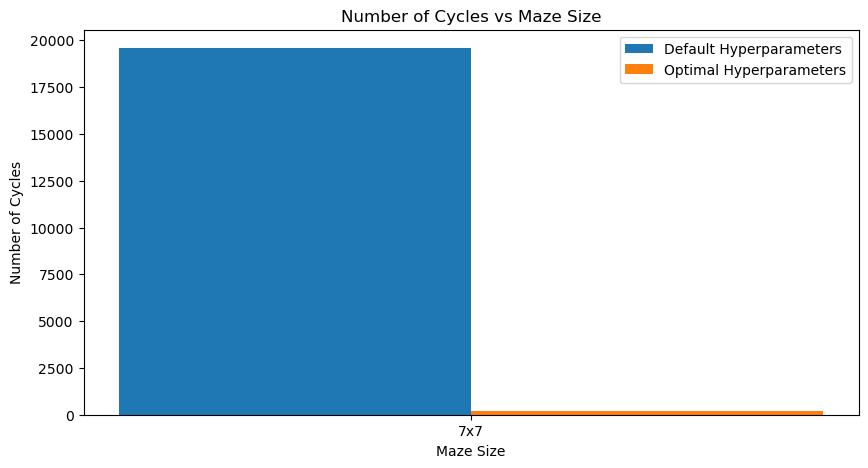

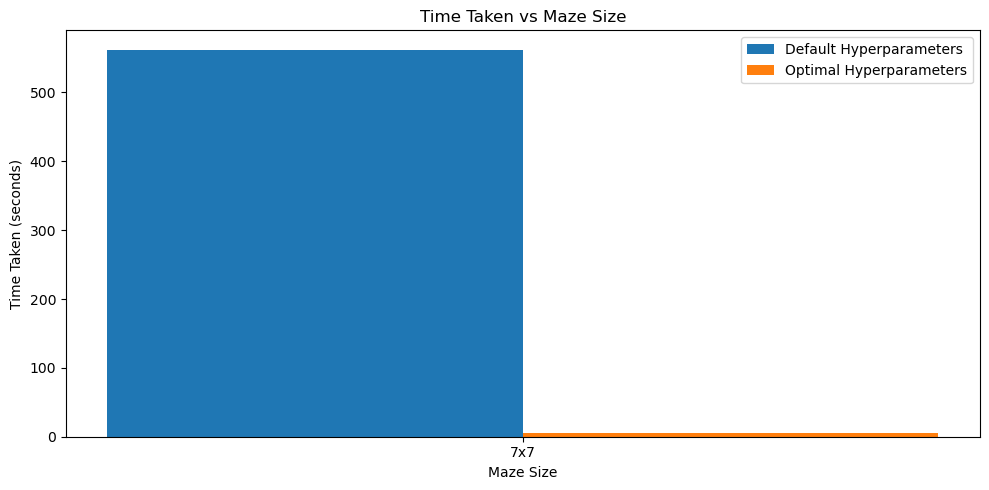

In [6]:
maze_sizes = [f"{size[0]}x{size[1]}" for size in sizes]
default_cycles = [result[0] for result in default_results]
optimal_cycles = [result[0] for result in optimal_results]
default_times = [result[1] for result in default_results]
optimal_times = [result[1] for result in optimal_results]

x = np.arange(len(maze_sizes))  # the label locations
width = 0.35  # the width of the bars

# Plotting cycles
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, default_cycles, width, label='Default Hyperparameters')
rects2 = ax.bar(x + width/2, optimal_cycles, width, label='Optimal Hyperparameters')

ax.set_xlabel('Maze Size')
ax.set_ylabel('Number of Cycles')
ax.set_title('Number of Cycles vs Maze Size')
ax.set_xticks(x)
ax.set_xticklabels(maze_sizes)
ax.legend()

# Plotting times
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, default_times, width, label='Default Hyperparameters')
rects2 = ax.bar(x + width/2, optimal_times, width, label='Optimal Hyperparameters')

ax.set_xlabel('Maze Size')
ax.set_ylabel('Time Taken (seconds)')
ax.set_title('Time Taken vs Maze Size')
ax.set_xticks(x)
ax.set_xticklabels(maze_sizes)
ax.legend()

plt.tight_layout()
plt.show()
